<a href="https://colab.research.google.com/github/andreacorvaglia1/Progetti/blob/master/codice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
Andrea Corvaglia 802487

# Import Librerie

In [0]:
# import the necessary packages
from keras.applications import VGG16
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import os
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from keras.models import Model


In [0]:
model = VGG16(weights="imagenet", include_top=False)
#https://keras.io/applications/#vgg16

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Si è deciso di vagliare tre possibili tagli, tutti in coda ad un max-pooling per sfruttare la riduzione di dimensionalità. I diversi tagli sono alla fine del primo, terzo e ultimo blocco di convoluzioni. In questo modo è possibile verificare quanto siano simili i task di classificazione rispetto alla rete originale, in base all'altezza del taglio.

# Data Set 

Il dataset proviene da Kaggle (https://www.kaggle.com/slothkong/10-monkey-species#n1017.jpg) e consiste in due file, training e validation. 

ll dataset è composto da due file, training e validation. Ogni cartella contiene 10 sotto cartelle con le diverse labels delle scimmie indicate come n0 ~ n9, ciascuno corrispondente a una specie provenente dal cladogramma della scimmia di Wikipedia. Le immagini hanno dimensione 400x300 o più grandi e in formato JPEG (quasi 1400 immagini).
Il task sarà naturalmente quello di classificare le 10 specie di scimmie.

Label mapping:

  - n0, alouatta_palliata
  - n1, erythrocebus_patas
  - n2, cacajao_calvus 
  - n3, macaca_fuscata   
  - n4, cebuella_pygmea
  - n5, cebus_capucinus
  - n6, mico_argentatus
  - n7, saimiri_sciureus 
  - n8, aotus_nigriceps
  - n9, trachypithecus_johnii

In [0]:
# Import del dataset tramite API di kaggle 

os.environ['KAGGLEUSERNAME'] = "andreacorvaglia" # username from the json file 
os.environ['KAGGLEKEY'] = "34f186703895ad8b84a75875c3c7b637" # key from the json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json
!pip install -q kaggle
!pip install -q kaggle-cli
!kaggle datasets download -d slothkong/10-monkey-species
!unzip /content/10-monkey-species.zip

In [0]:
def features_extractor(isTrain=True, cutDepth = 0):
# Funzione che carica le immagini dalle cartelle estraendo l'etichetta, le da in input alla VGG16
# caricata dopo averle pre processate e restituisce il dataset pronto alla classificazione.

# prende in argomento se si desidera estrarre il training o il validation set e il tipo di taglio
# da fare sulla VGG16

  x_data = []
  y_data = []
  # Train o Validation
  if isTrain :
    p = "/content/training/training"
  else : p = "/content/validation/validation/"
  # Altezza del taglio nella rete originale
  #lastLayer = ["block5_conv3","block3_conv3","block1_conv3"]
  lastLayer = ["block5_pool","block3_pool","block1_pool"]
  model_0 = VGG16(weights="imagenet", include_top=False)
  model = Model(inputs=model_0.input, outputs=model_0.get_layer(lastLayer[cutDepth]).output)

  subdir= os.listdir(p)
  # loop sulle classi
  for idx, dirname in enumerate(subdir):
      print(dirname)
      path=os.path.join(p,dirname)
      filenames=os.listdir(path)
      # loop sulle immagini
      for i, fname in enumerate(filenames):
        img_path = os.path.join(path,fname)
        # Caricamento delle immagini ridimensionandole ad un 224x224 pixels 
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        # Preprocessing dell'immagine espandendo le dimesioni
        x = np.expand_dims(x, axis=0)
        # e eseguendo i passi con cui si sono ottenuti i pesi che abbiamo caricato per la VGG16
        x = preprocess_input(x)
        features = np.array(model.predict(x)).flatten()

        x_data.append(features)
        y_data.append(int(list(dirname)[1]))

  return np.array(x_data), np.array(y_data)


def report (classifier):
# funzione che valuta le perfomance del classificatore in argomento 
  labels=classifier.predict(x_val)
  print(classification_report(labels, y_val))
  print("L'accuracy sul validation set è: \n")
  print(accuracy_score(labels, y_val))

In [0]:
'''
np.save("/content/drive/My Drive/Assignment 4/x_train", x_train)
np.save("/content/drive/My Drive/Assignment 4/y_train", y_train)
np.save("/content/drive/My Drive/Assignment 4/x_val", x_val)
np.save("/content/drive/My Drive/Assignment 4/y_val", y_val)
'''

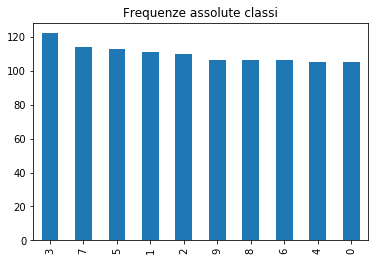

In [16]:
pd.value_counts(y_train).plot(kind='bar',title ="Frequenze assolute classi")
# Le classi risultano per lo più ben distribuite

# Classificazione

Per la parte finale di classificazione si è scelto di confrontare tre algoritmi:
  - Linear SVC 
  - Random Forest
  - K-Nearest Neighbourhood   

Per quanto riguarda invece la scelta degli iper-parametri dei modelli si è usata una grid search implementata con sklearn.
  

In [0]:
from sklearn.model_selection import GridSearchCV 

# defining parameter range 
param_grid = {'C': [0.1, 1, 10]}  
  
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 

In [59]:
grid.fit(x_train, y_train)  

#print(clf.coef_)
#print(clf.intercept_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.992, total=   3.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ............................... C=0.1, score=0.962, total=   5.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.975, total=   4.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.992, total=   5.1s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.962, total=   6.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.975, total=   3.6s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.992, total=   6.0s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.962, total=   6.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.975, total=   3.5s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   43.5s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [0]:
# Scelta del miglior taglio sul modello originale 

import gc
# viene usato "gc" insieme a "del" per conservare memoria sulla ram
acc = [] # lista delle accuracy
for cut in range(3):
    print("Tentativo: "+str(cut))
    # Estrazione dei dati processati attraverso la rete taglia alla profondità "cut"
    x_train, y_train = features_extractor(isTrain=True,cutDepth=cut)
    x_val, y_val = features_extractor(isTrain=False,cutDepth=cut)
    # classificazione col modello tradizionale
    clf.fit(x_train, y_train)  
    labels=clf.predict(x_val)
    # print dei risulrari
    print(classification_report(labels, y_val))
    print("L'accuracy sul validation set è: \n")
    print(accuracy_score(labels, y_val))
    acc.append(accuracy_score(labels, y_val))
    # liberazione della memoria
    del  x_train, y_train, x_val, y_val
    gc.collect()

acc = np.array(acc)
bestCut = argmax(acc)


Tentativo: 0
n5
n3
n9
n0
n6
n4
n1
n8
n7
n2
n5
n3
n9
n0
n6
n4
n1
n8
n7
n2
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        29
           1       1.00      0.97      0.98        29
           2       0.96      1.00      0.98        26
           3       1.00      1.00      1.00        30
           4       1.00      0.96      0.98        27
           5       0.96      0.96      0.96        28
           6       0.96      1.00      0.98        25
           7       0.96      0.96      0.96        28
           8       0.96      0.96      0.96        27
           9       0.88      1.00      0.94        23

    accuracy                           0.97       272
   macro avg       0.97      0.97      0.97       272
weighted avg       0.97      0.97      0.97       272

L'accuracy sul validation set è: 

0.9705882352941176
Tentativo: 1
n5
n3
n9
n0
n6
n4
n1
n8
n7
n2
n5
n3
n9
n0
n6
n4
n1
n8
n7
n2


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.54      0.78      0.64        18
           1       0.71      0.69      0.70        29
           2       0.96      0.90      0.93        29
           3       0.83      0.71      0.77        35
           4       0.81      0.75      0.78        28
           5       0.50      0.50      0.50        28
           6       0.88      0.72      0.79        32
           7       0.64      0.78      0.71        23
           8       0.81      0.85      0.83        26
           9       0.69      0.75      0.72        24

    accuracy                           0.74       272
   macro avg       0.74      0.74      0.74       272
weighted avg       0.75      0.74      0.74       272

L'accuracy sul validation set è: 

0.7389705882352942
Tentativo: 2
n5
n3
n9
n0
n6
n4
n1
n8
n7
n2
n5
n3
n9
n0
n6
n4
n1
n8
n7
n2


In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, max_depth=4).fit(X_train, y_train)  

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(x_train, y_train)  
labels=neigh.predict(x_val)
print(classification_report(labels, y_val))
print("L'accuracy sul validation set è: \n")
print(accuracy_score(labels, y_val))